# Word Frequency Distribution & Normality Analysis

This notebook analyzes whether word frequency counts resemble a normal distribution and explores alternative distributions (lognormal, Zipf). It also provides placeholders for future linguistic analyses.

## 1. Configure Notebook Environment & Imports

Set up Python environment, imports, plotting style, and random seed.

In [1]:
# Imports & configuration
from __future__ import annotations
import os
from pathlib import Path
import math
import sqlite3
from collections import Counter
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: nltk for more advanced tokenization (not needed for DB frequency extraction)
try:
    import nltk  # type: ignore
    # Uncomment if tokenization needed later:
    # nltk.download('punkt')
except Exception:
    nltk = None

sns.set_theme(style="whitegrid")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths / configuration
PROJECT_ROOT = Path.cwd()
DB_PATH = PROJECT_ROOT / 'output' / 'words_database.sqlite'
READONLY_URI = f"file:{DB_PATH.as_posix()}?mode=ro"  # Use SQLite URI for read-only access
USE_LOG_TRANSFORM = True
SAVE = True
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'visualizations' / 'frequency_normality'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using database: {DB_PATH}")
print(f"Output directory: {OUTPUT_DIR}")

Using database: c:\Users\Administrator\Desktop\projects\words\output\words_database.sqlite
Output directory: c:\Users\Administrator\Desktop\projects\words\output\visualizations\frequency_normality


## 2. Load Word Frequency Data From SQLite (Read-Only)

We query aggregate word frequencies directly from the SQLite database to avoid relying on CSV exports. The database is opened in read-only mode using the URI: `file:path?mode=ro`.

In [2]:
# Helper: connect read-only and load frequencies
QUERY = """
SELECT word, lemma, pos_tag, pos_category, total_frequency
FROM words
WHERE total_frequency IS NOT NULL
"""  # adjust table/column names if different

# Attempt to detect actual table if 'words' not present
POSSIBLE_TABLES = [
    'words', 'dutch_words_full', 'word_frequencies', 'tokens'
]

def load_frequencies() -> pd.DataFrame:
    global QUERY
    for table in POSSIBLE_TABLES:
        trial_query = QUERY.replace('FROM words', f'FROM {table}')
        try:
            with sqlite3.connect(READONLY_URI, uri=True) as conn:
                df = pd.read_sql(trial_query, conn)
            if not df.empty:
                print(f"Loaded from table '{table}' with {len(df):,} rows")
                return df
        except Exception as e:
            continue
    raise RuntimeError("Could not locate a table with expected frequency columns. Please verify schema.")

freq_df = load_frequencies()

# Basic cleaning / ensure integer frequencies
freq_df['total_frequency'] = freq_df['total_frequency'].astype(int)

# Drop potential duplicates by word (summing if needed)
if freq_df['word'].duplicated().any():
    print('Duplicate words detected: aggregating by sum of total_frequency')
    freq_df = (freq_df.groupby('word', as_index=False)
                      .agg({k: 'first' for k in freq_df.columns if k not in ['word','total_frequency']}
                           | {'total_frequency':'sum'}))

freq_df = freq_df.sort_values('total_frequency', ascending=False).reset_index(drop=True)
freq_df['rank'] = np.arange(1, len(freq_df)+1)
freq_df['relative_freq'] = freq_df['total_frequency'] / freq_df['total_frequency'].sum()

print(freq_df.head())
print(freq_df.describe(include='all').T.head())

Loaded from table 'words' with 841,764 rows
Duplicate words detected: aggregating by sum of total_frequency
     word   lemma pos_tag pos_category  total_frequency  rank  relative_freq
0    jaar    jaar    NOUN         noun           330608     1       0.006174
1    zegt  zeggen    VERB         verb           267520     2       0.004996
2  mensen    mens    NOUN         noun           232095     3       0.004334
3    twee    twee     NUM       number           219490     4       0.004099
4    gaat    gaan    VERB         verb           194080     5       0.003624
                    count  unique    top    freq       mean          std  min  \
word               548963  548963   jaar       1        NaN          NaN  NaN   
lemma              548963  500779  leven      12        NaN          NaN  NaN   
pos_tag            548963      14   NOUN  252450        NaN          NaN  NaN   
pos_category       548963      13   noun  252450        NaN          NaN  NaN   
total_frequency  548963.0

## 3. Descriptive Statistics & Distribution Preparation

Compute descriptive statistics on raw frequency counts and prepare transformed versions (log).

In [3]:
# Extract counts
counts_raw = freq_df['total_frequency'].to_numpy()

# Log transform (log1p handles zeros if any)
counts_log = np.log1p(counts_raw)

# Descriptive statistics function
def describe(arr: np.ndarray) -> dict:
    return {
        'n_unique': arr.size,
        'mean': float(np.mean(arr)),
        'median': float(np.median(arr)),
        'std': float(np.std(arr, ddof=1)),
        'min': float(np.min(arr)),
        'max': float(np.max(arr)),
        'skew': float(stats.skew(arr, bias=False)),
        'kurtosis_excess': float(stats.kurtosis(arr, fisher=True, bias=False)),
    }

stats_df = (pd.DataFrame([describe(counts_raw), describe(counts_log)], index=['raw_counts','log_counts'])
              .T)
print(stats_df)

if SAVE:
    stats_df.to_csv(OUTPUT_DIR / 'descriptive_statistics.csv')

                    raw_counts     log_counts
n_unique         548963.000000  548963.000000
mean                 97.546877       1.731240
median                2.000000       1.098612
std                1542.357991       1.495619
min                   1.000000       0.693147
max              330608.000000      12.708692
skew                 73.122066       2.053124
kurtosis_excess    9455.118606       4.671119


## 4. Histogram, KDE & Fitted Normal (Raw vs Log Counts)

Visualize distribution of raw counts and log-transformed counts, overlaying fitted normal PDFs.

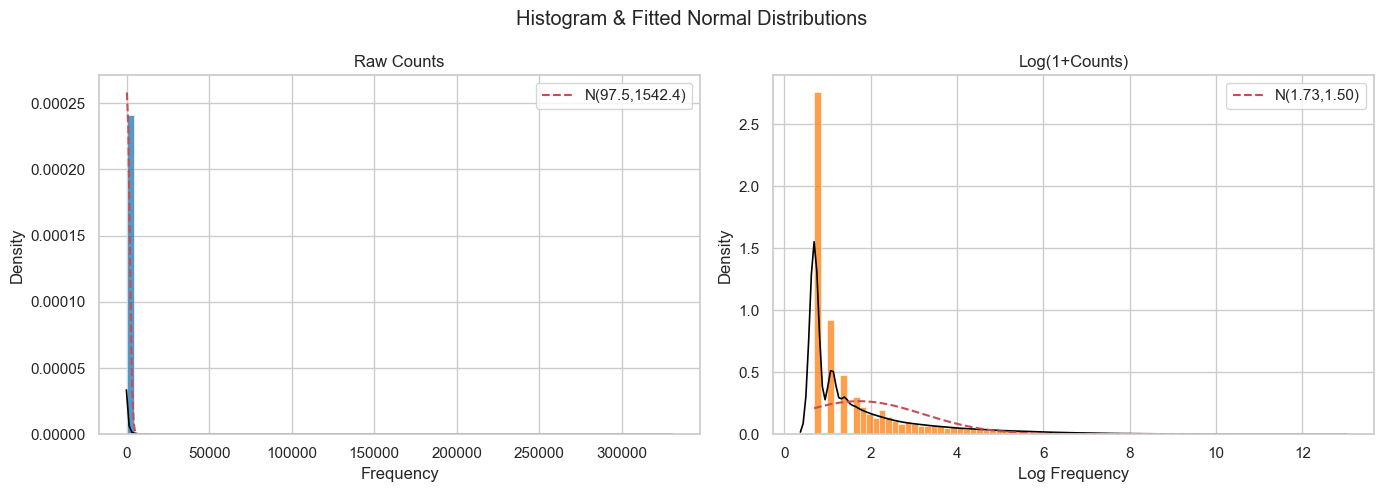

Normal fit raw mu=97.55 sigma=1542.36
Normal fit log mu=1.73 sigma=1.50


In [4]:
# Fit normals
mu_raw, sigma_raw = stats.norm.fit(counts_raw)
mu_log, sigma_log = stats.norm.fit(counts_log)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
# Raw
sns.histplot(counts_raw, bins=80, stat='density', ax=axes[0], color='#1f77b4')
sns.kdeplot(counts_raw, ax=axes[0], color='black', lw=1.2)
xs_raw = np.linspace(counts_raw.min(), counts_raw.max(), 400)
axes[0].plot(xs_raw, stats.norm.pdf(xs_raw, mu_raw, sigma_raw), 'r--', label=f'N({mu_raw:.1f},{sigma_raw:.1f})')
axes[0].set_title('Raw Counts')
axes[0].legend()
axes[0].set_xlabel('Frequency')

# Log
sns.histplot(counts_log, bins=80, stat='density', ax=axes[1], color='#ff7f0e')
sns.kdeplot(counts_log, ax=axes[1], color='black', lw=1.2)
xs_log = np.linspace(counts_log.min(), counts_log.max(), 400)
axes[1].plot(xs_log, stats.norm.pdf(xs_log, mu_log, sigma_log), 'r--', label=f'N({mu_log:.2f},{sigma_log:.2f})')
axes[1].set_title('Log(1+Counts)')
axes[1].legend()
axes[1].set_xlabel('Log Frequency')
plt.suptitle('Histogram & Fitted Normal Distributions')
plt.tight_layout()

if SAVE:
    fig.savefig(OUTPUT_DIR / 'histograms_normal_fit.png', dpi=150)
plt.show()

print(f"Normal fit raw mu={mu_raw:.2f} sigma={sigma_raw:.2f}")
print(f"Normal fit log mu={mu_log:.2f} sigma={sigma_log:.2f}")

## 5. Q-Q Plots

Quantile-Quantile plots compare empirical quantiles of the data to theoretical normal quantiles. Strong curvature indicates deviations from normality (e.g., heavy tails).

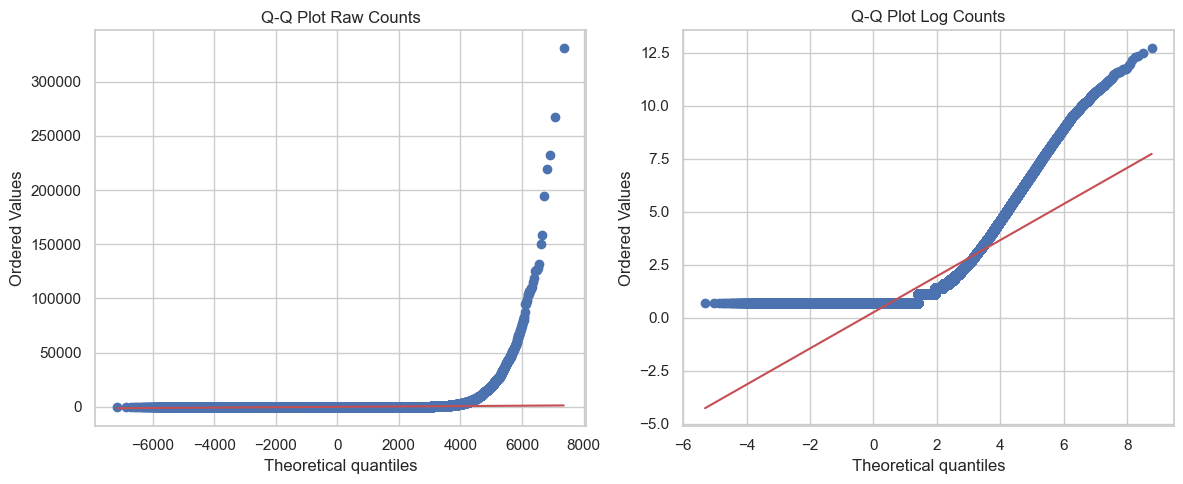

In [5]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
stats.probplot(counts_raw, dist='norm', sparams=(mu_raw, sigma_raw), plot=axes[0])
axes[0].set_title('Q-Q Plot Raw Counts')
stats.probplot(counts_log, dist='norm', sparams=(mu_log, sigma_log), plot=axes[1])
axes[1].set_title('Q-Q Plot Log Counts')
plt.tight_layout()
if SAVE:
    fig.savefig(OUTPUT_DIR / 'qq_plots.png', dpi=150)
plt.show()

## 6. Normality Tests

Apply several statistical tests (Shapiro-Wilk, Kolmogorov-Smirnov vs fitted normal, Anderson-Darling) to assess normality for raw and log-transformed counts.

In [6]:
def shapiro_safe(arr: np.ndarray, max_n: int = 5000):
    subset = arr if arr.size <= max_n else np.random.choice(arr, size=max_n, replace=False)
    return stats.shapiro(subset)

# Raw tests
shapiro_raw = shapiro_safe(counts_raw)
ks_raw = stats.kstest(counts_raw, 'norm', args=(mu_raw, sigma_raw))
anderson_raw = stats.anderson(counts_raw, dist='norm')

# Log tests
shapiro_log = shapiro_safe(counts_log)
ks_log = stats.kstest(counts_log, 'norm', args=(mu_log, sigma_log))
anderson_log = stats.anderson(counts_log, dist='norm')

rows = [
    {'data':'raw','test':'Shapiro-Wilk','statistic':shapiro_raw.statistic,'p_value':shapiro_raw.pvalue},
    {'data':'raw','test':'Kolmogorov-Smirnov','statistic':ks_raw.statistic,'p_value':ks_raw.pvalue},
    {'data':'raw','test':'Anderson-Darling','statistic':anderson_raw.statistic,'critical_values':anderson_raw.critical_values.tolist(),'significance_level':anderson_raw.significance_level.tolist()},
    {'data':'log','test':'Shapiro-Wilk','statistic':shapiro_log.statistic,'p_value':shapiro_log.pvalue},
    {'data':'log','test':'Kolmogorov-Smirnov','statistic':ks_log.statistic,'p_value':ks_log.pvalue},
    {'data':'log','test':'Anderson-Darling','statistic':anderson_log.statistic,'critical_values':anderson_log.critical_values.tolist(),'significance_level':anderson_log.significance_level.tolist()},
]

normality_df = pd.DataFrame(rows)
print(normality_df)

if SAVE:
    normality_df.to_json(OUTPUT_DIR / 'normality_tests.json', orient='records', indent=2)
    normality_df.to_csv(OUTPUT_DIR / 'normality_tests.csv', index=False)

  data                test      statistic       p_value  \
0  raw        Shapiro-Wilk       0.059562  2.103674e-94   
1  raw  Kolmogorov-Smirnov       0.475044  0.000000e+00   
2  raw    Anderson-Darling  194495.397632           NaN   
3  log        Shapiro-Wilk       0.732819  3.482477e-67   
4  log  Kolmogorov-Smirnov       0.243813  0.000000e+00   
5  log    Anderson-Darling   49810.127606           NaN   

                       critical_values           significance_level  
0                                  NaN                          NaN  
1                                  NaN                          NaN  
2  [0.576, 0.656, 0.787, 0.918, 1.092]  [15.0, 10.0, 5.0, 2.5, 1.0]  
3                                  NaN                          NaN  
4                                  NaN                          NaN  
5  [0.576, 0.656, 0.787, 0.918, 1.092]  [15.0, 10.0, 5.0, 2.5, 1.0]  


## 7. Alternative Distribution Fits (Lognormal & Zipf Approximation)

Many linguistic frequency distributions follow heavy-tailed laws (Zipf / lognormal). Fit lognormal and approximate Zipf exponent for comparison.

Lognormal params: shape=1.7228, loc=0.0000, scale=3.80
Estimated Zipf exponent s ~= 1.707


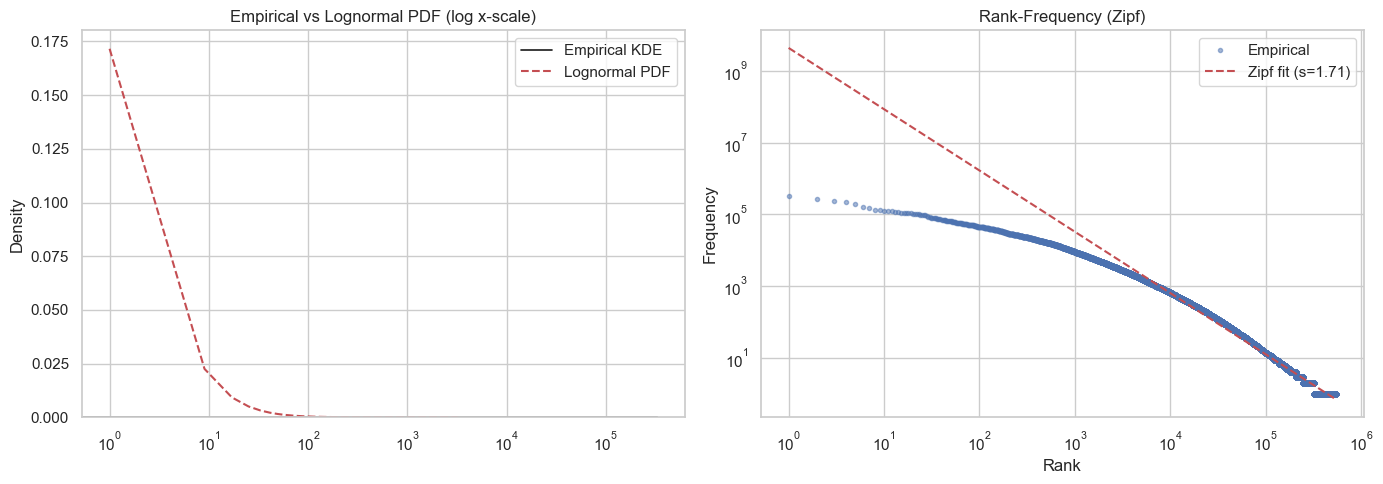

  distribution           AIC           BIC  log_likelihood
0       normal  9.617842e+06  9.617864e+06   -4.808919e+06
1    lognormal  3.619444e+06  3.619478e+06   -1.809719e+06


In [7]:
# Lognormal fit (force loc=0 to reduce over-parameterization)
shape, loc, scale = stats.lognorm.fit(counts_raw, floc=0)
print(f"Lognormal params: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.2f}")

# Zipf-like exponent via linear regression on log(rank) vs log(freq)
# Filter out zeros and maybe extreme tail for stability
rank = freq_df['rank'].to_numpy()
mask = (counts_raw > 0)
log_rank = np.log(rank[mask])
log_freq = np.log(counts_raw[mask])
# Ordinary least squares for slope
A = np.vstack([log_rank, np.ones_like(log_rank)]).T
slope, intercept = np.linalg.lstsq(A, log_freq, rcond=None)[0]
zipf_exponent = -slope  # For Zipf: freq ~ rank^{-s}
print(f"Estimated Zipf exponent s ~= {zipf_exponent:.3f}")

# Plot empirical vs fitted lognormal PDF (on log scale for clarity)
fig, ax = plt.subplots(1,2, figsize=(14,5))
# PDF comparison
xs = np.linspace(counts_raw.min(), np.percentile(counts_raw, 99.5), 400)
emp_density = sns.kdeplot(counts_raw, ax=ax[0], color='k', lw=1.2, label='Empirical KDE')
lognorm_pdf = stats.lognorm.pdf(xs, shape, loc=loc, scale=scale)
ax[0].plot(xs, lognorm_pdf, 'r--', label='Lognormal PDF')
ax[0].set_xscale('log')
ax[0].set_title('Empirical vs Lognormal PDF (log x-scale)')
ax[0].legend()

# Rank-frequency plot with Zipf line
ax[1].loglog(rank, counts_raw, marker='.', linestyle='none', alpha=0.5, label='Empirical')
zipf_line = np.exp(intercept) * rank ** slope
ax[1].loglog(rank, zipf_line, 'r--', label=f'Zipf fit (s={zipf_exponent:.2f})')
ax[1].set_xlabel('Rank')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Rank-Frequency (Zipf)')
ax[1].legend()
plt.tight_layout()
if SAVE:
    fig.savefig(OUTPUT_DIR / 'alternative_fits.png', dpi=150)
plt.show()

# Compute simple AIC/BIC for normal vs lognormal (raw counts) using fitted PDFs, excluding zeros
valid = counts_raw > 0
ll_norm = np.sum(stats.norm.logpdf(counts_raw[valid], mu_raw, sigma_raw))
ll_lognorm = np.sum(stats.lognorm.logpdf(counts_raw[valid], shape, loc=loc, scale=scale))
# Parameter counts: normal (2), lognormal (3: shape, loc, scale but loc fixed -> 2 effective + shape => 3)
k_norm = 2
k_lognorm = 3
n = valid.sum()
AIC_norm = 2*k_norm - 2*ll_norm
AIC_lognorm = 2*k_lognorm - 2*ll_lognorm
BIC_norm = k_norm * math.log(n) - 2*ll_norm
BIC_lognorm = k_lognorm * math.log(n) - 2*ll_lognorm
fit_compare = pd.DataFrame([
    {'distribution':'normal','AIC':AIC_norm,'BIC':BIC_norm,'log_likelihood':ll_norm},
    {'distribution':'lognormal','AIC':AIC_lognorm,'BIC':BIC_lognorm,'log_likelihood':ll_lognorm},
])
print(fit_compare)
if SAVE:
    fit_compare.to_csv(OUTPUT_DIR / 'fit_information_criteria.csv', index=False)

## 8. Save Summary & Notes

Consolidate key insights and save a short textual summary for quick reference.

In [8]:
summary_lines = []
summary_lines.append(f"Total unique words: {len(freq_df):,}")
summary_lines.append(f"Top word: {freq_df.iloc[0]['word']} (freq={freq_df.iloc[0]['total_frequency']:,})")
summary_lines.append(f"Normal fit raw mu={mu_raw:.2f} sigma={sigma_raw:.2f}")
summary_lines.append(f"Normal fit log mu={mu_log:.2f} sigma={sigma_log:.2f}")
summary_lines.append(f"Zipf exponent estimate s~={zipf_exponent:.3f}")
summary_lines.append("Normality tests (see JSON/CSV for details):")
for _, r in normality_df.iterrows():
    if 'p_value' in r and not pd.isna(r['p_value']):
        summary_lines.append(f"  {r['data']} {r['test']}: stat={r['statistic']:.4g}, p={r['p_value']:.3g}")

summary_text = '\n'.join(summary_lines)
print(summary_text)

if SAVE:
    with open(OUTPUT_DIR / 'summary.txt','w', encoding='utf-8') as f:
        f.write(summary_text + '\n')


Total unique words: 548,963
Top word: jaar (freq=330,608)
Normal fit raw mu=97.55 sigma=1542.36
Normal fit log mu=1.73 sigma=1.50
Zipf exponent estimate s~=1.707
Normality tests (see JSON/CSV for details):
  raw Shapiro-Wilk: stat=0.05956, p=2.1e-94
  raw Kolmogorov-Smirnov: stat=0.475, p=0
  log Shapiro-Wilk: stat=0.7328, p=3.48e-67
  log Kolmogorov-Smirnov: stat=0.2438, p=0


## 9. Placeholder: Future N-gram Analysis

TODO: Implement bigram/trigram extraction directly from database token stream if available, or reconstruct from articles.

## 10. Placeholder: Sentiment / Topic Modeling

TODO: Integrate sentiment lexicons or run LDA / BERTopic on article texts for thematic evolution vs frequency distribution.

## 11. Placeholder: Vocabulary Growth (Heaps' Law)

TODO: Simulate incremental corpus accumulation and model V(N) = K * N^beta. Compare empirical beta to typical 0.4–0.6 range.